<a href="https://colab.research.google.com/github/superbunny38/Multi-Object-Semantic-Segmentation/blob/main/models/Professional_NewLossPSPNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Libraries

import time
import os
import PIL
import copy
import torch
import torchvision
import numpy as np
import albumentations
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import random
import math
import time
import pandas as pd
import numpy as np
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import urllib.request
import zipfile
import tarfile
!pip install timm
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html
!pip install torchtext==0.9.1
import io
import re
import pickle
import random
from pathlib import Path
from itertools import repeat
from operator import itemgetter, mul
from functools import partial, reduce
from multiprocessing import cpu_count
from typing import Callable, BinaryIO, Match, Pattern, Tuple, Union, Optional

import torch
import numpy as np
from PIL import Image, ImageOps
from torch import Tensor
from torchvision import transforms
from skimage.transform import resize
#from torch._six import container_abcs
from torch.utils.data import Dataset, DataLoader, Sampler
from torch.utils.data import Dataset
# from modules.utils import load_json
import numpy as np
from PIL import Image
import os
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix 
import pandas as pd
import os
import sys
from torch import nn

from datetime import datetime, timezone, timedelta 
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import logging
import torch
import csv
import torchvision.transforms as transforms
import numpy as np
import torch
import torch.optim as optim
from time import time
from tqdm import tqdm
from torch.nn import functional as F
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch.optim as optim
from itertools import product
import logging
import random
import pickle
import shutil
import json
import yaml
import csv
import os 
from scipy.stats import entropy
import os.path as osp
from PIL import Image
import torch.utils.data as data
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/2022/LungSegmentation/utils.py /content

In [ ]:
!pip install medpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 151 kB 5.4 MB/s 
     |████████████████████████████████| 48.4 MB 1.3 MB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp37-cp37m-linux_x86_64.whl size=754462 sha256=63608a18bfeeb93a4bb6027910a6c8e5c4e6cb329fa8c7153c025c97f9addc68
  Stored in directory: /root/.cache/pip/wheels/b0/57/3a/da1183f22a6afb42e11138daa6a759de233fd977a984333602
Successfully built medpy


In [ ]:
#@title Utils
from utils import map_, class2one_hot, one_hot2dist, id_
from utils import one_hot, depth
import numpy as np

def dice_coef(y_true, y_pred, epsilon=1e-6):
    y_true_flatten = np.asarray(y_true).astype(np.bool)
    y_pred_flatten = np.asarray(y_pred).astype(np.bool)

    if not np.sum(y_true_flatten) + np.sum(y_pred_flatten):
        return 1.0

    return (2. * np.sum(y_true_flatten * y_pred_flatten)) /\
           (np.sum(y_true_flatten) + np.sum(y_pred_flatten) + epsilon)

def cut(W,H,lam):
        
    ######define the size of box######
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int64(W * cut_rat)
    cut_h = np.int64(H * cut_rat) 
    ######define the size of box######
    
    #####randomly choose where to cut#####
    cx = np.random.randint(W) # uniform distribution
    cy = np.random.randint(H)
    #####randomly choose where to cut#####

    bbx1 = np.clip(cx - cut_w // 2, 0, W) # Cut, return coordinates of the box 
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

# Data

## Get Data, Split, Make List

In [ ]:
#get data from gdrive
import shutil
!mkdir data
file1 = "/content/drive/MyDrive/2022/LungSegmentation/Lung_Segmentation.zip"
#file1 = "/content/drive/MyDrive/train.zip"
shutil.unpack_archive(file1, "/content/data")

mkdir: cannot create directory ‘data’: File exists


In [ ]:
anno_dir = '/content/drive/MyDrive/2022/LungSegmentation/annotation/'
data_dir = '/content/data/image/'
aug_dir = '/content/drive/MyDrive/2022/LungSegmentation/histogram_eq_image/'

In [ ]:
first_anno = os.listdir(anno_dir)[0]
first_anno

'resize_CHNCXR_0539_1.png'

In [ ]:
os.listdir(data_dir)[0]

'resize_CHNCXR_0271_0.png'

In [ ]:
assert len(os.listdir(anno_dir)) == len(os.listdir(data_dir))
print("entire data:",len(os.listdir(data_dir)))

entire data: 566


In [ ]:
train_size = int(np.ceil(len(os.listdir(data_dir))*.7))
val_size = len(os.listdir(data_dir))-train_size
print(f"train size: {train_size}, test_size: {val_size}")

train size: 397, test_size: 169


In [ ]:
train_names = os.listdir(data_dir)[:train_size]
val_names = os.listdir(data_dir)[train_size:]

In [ ]:
train_names[:5]

['resize_CHNCXR_0271_0.png',
 'resize_CHNCXR_0589_1.png',
 'resize_CHNCXR_0627_1.png',
 'resize_CHNCXR_0131_0.png',
 'resize_CHNCXR_0557_1.png']

In [ ]:
train_img_list = []
test_img_list = []
train_aug_list = []
train_anno_list = []
test_anno_list = []

for train_name in train_names:
  train_img_list.append(data_dir+train_name)
  train_anno_list.append(anno_dir + train_name)
  train_aug_list.append(aug_dir+train_name)

for test_name in val_names:
  test_img_list.append(data_dir+test_name)
  test_anno_list.append(anno_dir+test_name)

In [ ]:
train_img_list[:5]

['/content/data/image/resize_CHNCXR_0271_0.png',
 '/content/data/image/resize_CHNCXR_0589_1.png',
 '/content/data/image/resize_CHNCXR_0627_1.png',
 '/content/data/image/resize_CHNCXR_0131_0.png',
 '/content/data/image/resize_CHNCXR_0557_1.png']

In [ ]:
train_aug_list[:5]

['/content/drive/MyDrive/2022/LungSegmentation/histogram_eq_image/resize_CHNCXR_0271_0.png',
 '/content/drive/MyDrive/2022/LungSegmentation/histogram_eq_image/resize_CHNCXR_0589_1.png',
 '/content/drive/MyDrive/2022/LungSegmentation/histogram_eq_image/resize_CHNCXR_0627_1.png',
 '/content/drive/MyDrive/2022/LungSegmentation/histogram_eq_image/resize_CHNCXR_0131_0.png',
 '/content/drive/MyDrive/2022/LungSegmentation/histogram_eq_image/resize_CHNCXR_0557_1.png']

In [ ]:
train_anno_list[:5]

['/content/drive/MyDrive/2022/LungSegmentation/annotation/resize_CHNCXR_0271_0.png',
 '/content/drive/MyDrive/2022/LungSegmentation/annotation/resize_CHNCXR_0589_1.png',
 '/content/drive/MyDrive/2022/LungSegmentation/annotation/resize_CHNCXR_0627_1.png',
 '/content/drive/MyDrive/2022/LungSegmentation/annotation/resize_CHNCXR_0131_0.png',
 '/content/drive/MyDrive/2022/LungSegmentation/annotation/resize_CHNCXR_0557_1.png']

In [ ]:
print(f"train img size: {len(train_img_list)} train anno size: {len(train_anno_list)}, test img size: {len(test_img_list)} test anno size: {len(test_anno_list)}")

train img size: 397 train anno size: 397, test img size: 169 test anno size: 169


get pretrained weights

In [ ]:
weights_dir = "./weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

In [ ]:
!cp /content/drive/MyDrive/2022/LungSegmentation/pspnet50_ADE20K.pth /content/weights

# BD+DC Loss

In [ ]:
imgs = []
batchs = []
for batch_img, batch_label in dataloaders_dict['val']:
  imgs.append(batch_img)
  batchs.append(batch_label)

In [ ]:
batch_img, batch_img2 = imgs[0],imgs[1]
batch_label, batch_label2 = batchs[0],batchs[1]

In [ ]:
batch_img, batch_label= next(iter(dataloaders_dict['val']))

In [ ]:
batch_img2, batch_label2 = next(iter(dataloaders_dict['val']))

In [ ]:
batch_img, batch_label = batch_img.cuda(),batch_label.cuda()
batch_img2, batch_label2 = batch_img2.cuda(),batch_label2.cuda()

In [ ]:
batch_img.size()#batchsize = 3

torch.Size([3, 3, 475, 475])

In [ ]:
#batch_img, batch_label = batch_img.cuda(),batch_label.cuda()
psp_net.cpu()
psp_net.eval()
batch_out = psp_net(batch_img)

In [ ]:
#batch_img2, batch_label2 = batch_img2.cuda(),batch_label2.cuda()
psp_net.cpu()
psp_net.eval()
batch_out2 = psp_net(batch_img2)

In [ ]:
#outputs = psp_net(x)
y = batch_out[0] 

In [ ]:
y.size()

torch.Size([3, 3, 475, 475])

In [ ]:
z = y[0].cpu().detach().numpy()
z.shape

(3, 475, 475)

In [ ]:
np.argmax(z, axis=0).shape

(475, 475)

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from scipy.ndimage import distance_transform_edt
from skimage import segmentation as skimage_seg

softmax_helper = lambda x: F.softmax(x, 1)

def compute_sdf(img_gt, out_shape):
    """
    compute the signed distance map of binary mask
    input: segmentation, shape = (batch_size, x, y, z)
    output: the Signed Distance Map (SDM) 
    sdf(x) = 0; x in segmentation boundary
             -inf|x-y|; x in segmentation
             +inf|x-y|; x out of segmentation
    """

    img_gt = img_gt.astype(np.uint8)

    gt_sdf = np.zeros(out_shape)

    for b in range(out_shape[0]): # batch size
        for c in range(1, out_shape[1]): # channel
            posmask = img_gt[b][c].astype(np.bool)
            if posmask.any():
                negmask = ~posmask
                posdis = distance_transform_edt(posmask)
                negdis = distance_transform_edt(negmask)
                boundary = skimage_seg.find_boundaries(posmask, mode='inner').astype(np.uint8)
                sdf = negdis - posdis
                sdf[boundary==1] = 0
                gt_sdf[b][c] = sdf

    return gt_sdf

class BDLoss(nn.Module):
    def __init__(self):
        """
        compute boudary loss
        only compute the loss of foreground
        ref: https://github.com/LIVIAETS/surface-loss/blob/108bd9892adca476e6cdf424124bc6268707498e/losses.py#L74
        """
        super(BDLoss, self).__init__()
        # self.do_bg = do_bg

    def forward(self, net_output, gt):
        """
        net_output: (batch_size, class, x,y,z)
        target: ground truth, shape: (batch_size, 1, x,y,z)
        bound: precomputed distance map, shape (batch_size, class, x,y,z)
        """
        net_output = softmax_helper(net_output)
        with torch.no_grad():
            if len(net_output.shape) != len(gt.shape):
                gt = gt.view((gt.shape[0], 1, *gt.shape[1:]))

            if all([i == j for i, j in zip(net_output.shape, gt.shape)]):
                # if this is the case then gt is probably already a one hot encoding
                y_onehot = gt
            else:
                gt = gt.long()
                y_onehot = torch.zeros(net_output.shape)
                if net_output.device.type == "cuda":
                    y_onehot = y_onehot.cuda(net_output.device.index)
                y_onehot.scatter_(1, gt, 1)
            gt_sdf = compute_sdf(y_onehot.cpu().numpy(), net_output.shape)

        phi = torch.from_numpy(gt_sdf)
        if phi.device != net_output.device:
            phi = phi.to(net_output.device).type(torch.float32)
        # pred = net_output[:, 1:, ...].type(torch.float32)
        # phi = phi[:,1:, ...].type(torch.float32)

        multipled = torch.einsum("bcxy,bcxy->bcxy", net_output[:, 1:, ...], phi[:, 1:, ...])
        bd_loss = multipled.mean()

        return bd_loss

In [ ]:
#ref: https://github.com/JunMa11/SegLoss/blob/71b14900e91ea9405d9705c95b451fc819f24c70/test/loss_functions/boundary_loss.py#L131
#from nnunet.training.loss_functions.TopK_loss import TopKLoss
#from nnunet.utilities.nd_softmax import softmax_helper
#from nnunet.training.loss_functions.ND_Crossentropy import CrossentropyND
#from nnunet.utilities.tensor_utilities import sum_tensor
from torch import nn
from scipy.ndimage import distance_transform_edt
from skimage import segmentation as skimage_seg
import numpy as np

import numpy as np
import torch
from torch import nn


def sum_tensor(inp, axes, keepdim=False):
    axes = np.unique(axes).astype(int)
    if keepdim:
        for ax in axes:
            inp = inp.sum(int(ax), keepdim=True)
    else:
        for ax in sorted(axes, reverse=True):
            inp = inp.sum(int(ax))
    return inp

def get_tp_fp_fn(net_output, gt, axes=None, mask=None, square=False):
    """
    net_output must be (b, c, x, y(, z)))
    gt must be a label map (shape (b, 1, x, y(, z)) OR shape (b, x, y(, z))) or one hot encoding (b, c, x, y(, z))
    if mask is provided it must have shape (b, 1, x, y(, z)))
    :param net_output:
    :param gt:
    :param axes:
    :param mask: mask must be 1 for valid pixels and 0 for invalid pixels
    :param square: if True then fp, tp and fn will be squared before summation
    :return:
    """
    if axes is None:
        axes = tuple(range(2, len(net_output.size())))

    shp_x = net_output.shape
    shp_y = gt.shape

    with torch.no_grad():
        if len(shp_x) != len(shp_y):
            gt = gt.view((shp_y[0], 1, *shp_y[1:]))

        if all([i == j for i, j in zip(net_output.shape, gt.shape)]):
            # if this is the case then gt is probably already a one hot encoding
            y_onehot = gt
        else:
            gt = gt.long()
            y_onehot = torch.zeros(shp_x)
            if net_output.device.type == "cuda":
                y_onehot = y_onehot.cuda(net_output.device.index)
            y_onehot.scatter_(1, gt, 1)

    tp = net_output * y_onehot
    fp = net_output * (1 - y_onehot)
    fn = (1 - net_output) * y_onehot

    if mask is not None:
        tp = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(tp, dim=1)), dim=1)
        fp = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(fp, dim=1)), dim=1)
        fn = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(fn, dim=1)), dim=1)

    if square:
        tp = tp ** 2
        fp = fp ** 2
        fn = fn ** 2

    tp = sum_tensor(tp, axes, keepdim=False)
    fp = sum_tensor(fp, axes, keepdim=False)
    fn = sum_tensor(fn, axes, keepdim=False)

    return tp, fp, fn


class SoftDiceLoss(nn.Module):
    def __init__(self, apply_nonlin=None, batch_dice=False, do_bg=True, smooth=1.,
                 square=False):
        """
        """
        super(SoftDiceLoss, self).__init__()

        self.square = square
        self.do_bg = do_bg
        self.batch_dice = batch_dice
        self.apply_nonlin = apply_nonlin
        self.smooth = smooth

    def forward(self, x, y, loss_mask=None):
        shp_x = x.shape

        if self.batch_dice:
            axes = [0] + list(range(2, len(shp_x)))
        else:
            axes = list(range(2, len(shp_x)))

        if self.apply_nonlin is not None:
            x = self.apply_nonlin(x)

        tp, fp, fn = get_tp_fp_fn(x, y, axes, loss_mask, self.square)

        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)

        if not self.do_bg:
            if self.batch_dice:
                dc = dc[1:]
            else:
                dc = dc[:, 1:]
        dc = dc.mean()

        return 1-dc




class DC_and_BD_loss(nn.Module):
    def __init__(self, soft_dice_kwargs, bd_kwargs, aggregate="sum"):
        super(DC_and_BD_loss, self).__init__()
        self.aggregate = aggregate
        self.dc = SoftDiceLoss(apply_nonlin=softmax_helper, **soft_dice_kwargs)
        self.bd = BDLoss(**bd_kwargs)
        

    def forward(self, net_output, target):
        dc_loss = self.dc(net_output, target)
        bd_loss = self.bd(net_output, target)
        if self.aggregate == "sum":
            result = 0.01*dc_loss + (1-0.01)*bd_loss
        else:
            raise NotImplementedError("nah son") 
        return result       


In [ ]:
new_loss = DC_and_BD_loss(soft_dice_kwargs= {'batch_dice' : True, 'do_bg' : False, 'smooth' : 1e-5, 'square' : False}, bd_kwargs = {})

In [ ]:
bd_loss = BDLoss()

In [ ]:
bd_loss(batch_out[0],batch_label)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


tensor(-2.7482, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
bd_loss(batch_out[0],batch_label2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


tensor(-1.8844, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
bd_loss(batch_out2[0],batch_label)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


tensor(-2.1921, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
bd_loss(batch_out2[0],batch_label2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


tensor(-2.4845, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
def compute_gt_dtm(img_gt, out_shape):
    """
    compute the distance transform map of foreground in ground gruth.
    input: segmentation, shape = (batch_size, class, x, y, z)
    output: the foreground Distance Map (SDM) 
    dtm(x) = 0; x in segmentation boundary
             inf|x-y|; x in segmentation
    """

    fg_dtm = np.zeros(out_shape)

    for b in range(out_shape[0]): # batch size
        for c in range(1, out_shape[1]): # class; exclude the background class
            posmask = img_gt[b][c].astype(np.bool)
            if posmask.any():
                posdis = distance_transform_edt(posmask)
                fg_dtm[b][c] = posdis

    return fg_dtm

def compute_pred_dtm(img_gt, out_shape):
    """
    compute the distance transform map of foreground in prediction.
    input: segmentation, shape = (batch_size, class, x, y, z)
    output: the foreground Distance Map (SDM) 
    dtm(x) = 0; x in segmentation boundary
             inf|x-y|; x in segmentation
    """

    fg_dtm = np.zeros(out_shape)

    for b in range(out_shape[0]): # batch size
        for c in range(1, out_shape[1]): # class; exclude the background class
            posmask = img_gt[b][c]>0.5
            if posmask.any():
                posdis = distance_transform_edt(posmask)
                fg_dtm[b][c] = posdis

    return fg_dtm
class HDLoss(nn.Module):
    def __init__(self):
        """
        compute haudorff loss for binary segmentation
        https://arxiv.org/pdf/1904.10030v1.pdf        
        """
        super(HDLoss, self).__init__()


    def forward(self, net_output, gt):
        """
        net_output: (batch_size, c, x,y,z)
        target: ground truth, shape: (batch_size, c, x,y,z)
        """
        net_output = softmax_helper(net_output)
        # one hot code for gt
        with torch.no_grad():
            if len(net_output.shape) != len(gt.shape):
                gt = gt.view((gt.shape[0], 1, *gt.shape[1:]))

            if all([i == j for i, j in zip(net_output.shape, gt.shape)]):
                # if this is the case then gt is probably already a one hot encoding
                y_onehot = gt
            else:
                gt = gt.long()
                y_onehot = torch.zeros(net_output.shape)
                if net_output.device.type == "cuda":
                    y_onehot = y_onehot.cuda(net_output.device.index)
                y_onehot.scatter_(1, gt, 1)
        # print('hd loss.py', net_output.shape, y_onehot.shape)

        with torch.no_grad():
            pc_dist = compute_pred_dtm(net_output.cpu().numpy(), net_output.shape)
            gt_dist = compute_gt_dtm(y_onehot.cpu().numpy(), net_output.shape)
            dist = pc_dist**2 + gt_dist**2 # \alpha=2 in eq(8)
            # print('pc_dist.shape: ', pc_dist.shape, 'gt_dist.shape', gt_dist.shape)
        
        pred_error = (net_output - y_onehot)**2

        dist = torch.from_numpy(dist)
        if dist.device != pred_error.device:
            dist = dist.to(pred_error.device).type(torch.float32)

        multipled = torch.einsum("bcxy,bcxy->bcxy", pred_error[:,1:,...], dist[:,1:,...])
        hd_loss = multipled.mean()

        return hd_loss

In [ ]:
hd_loss = HDLoss()

In [ ]:
hd_loss(batch_out[0],batch_label)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


tensor(0.1924, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
bd_loss(batch_out[0],batch_label2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


tensor(-1.8844, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
bd_loss(batch_out2[0],batch_label2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


tensor(-2.4845, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
bd_loss(batch_out2[0],batch_label)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


tensor(-2.1921, dtype=torch.float64, grad_fn=<MeanBackward0>)

## Define Dataset

In [ ]:
!cp /content/drive/MyDrive/2022/LungSegmentation/data_augumentation.py /content

In [ ]:
from data_augumentation import *

In [ ]:
class DataTransform():
  def __init__(self, input_size, color_mean, color_std):#input_size: size you want the image to be
    self.data_transform = {
            'train': Compose([
                Resize(input_size), 
                Normalize_Tensor(color_mean, color_std)#Normalization+ToTensor
            ]),
            'train_aug': Compose([
                #RandomMirror(),
                Resize(input_size),  # リサイズ(input_size)
                Normalize_Tensor(color_mean, color_std)  # 色情報の標準化とテンソル化
            ]),
            'val': Compose([
                Resize(input_size),
                Normalize_Tensor(color_mean, color_std)#Normalization+ToTensor
            ])
        }
  def __call__(self, phase, img, anno_class_img):
        return self.data_transform[phase](img, anno_class_img)

In [ ]:
class LungDataset(data.Dataset):
  def __init__(self, img_list, anno_list, phase, transform):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase#train or test
        self.transform = transform
        #self.disttransform = dist_map_transform([1, 1], 2)
  
  def __len__(self):
        return len(self.img_list)

  def __getitem__(self, index):
        img, anno_class_img = self.pull_item(index)
        return img, anno_class_img

  def pull_item(self, index):
        image_file_path = self.img_list[index]
        original_img = Image.open(image_file_path)#height, width, channel
        img = Image.open(image_file_path)
        anno_file_path = self.anno_list[index]
        anno_class_img = Image.open(anno_file_path)

        img, anno_class_img = self.transform(self.phase, img, anno_class_img)
        #dist_map = self.disttransform(original_img)
        return img, anno_class_img

In [ ]:
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

In [ ]:
train_dataset = LungDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

In [ ]:
train_aug_dataset = LungDataset(train_aug_list, train_anno_list, phase="train_aug", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

In [ ]:
val_dataset = LungDataset(test_img_list, test_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

In [ ]:
len(train_dataset)

397

In [ ]:
len(train_aug_dataset)

397

In [ ]:
len(val_dataset)

169

In [ ]:
print(train_dataset.__getitem__(0)[0].shape)#img
print(train_dataset.__getitem__(0)[1].shape)#annotation

torch.Size([3, 475, 475])
torch.Size([475, 475])


In [ ]:
print(train_aug_dataset.__getitem__(0)[0].shape)#img
print(train_aug_dataset.__getitem__(0)[1].shape)#annotation

torch.Size([3, 475, 475])
torch.Size([475, 475])


In [ ]:
print(val_dataset.__getitem__(0)[0].shape)#img
print(val_dataset.__getitem__(0)[1].shape)#annotation

torch.Size([3, 475, 475])
torch.Size([475, 475])


In [ ]:
np.unique(val_dataset.__getitem__(0)[1])#0: background, 30: left, 60: right

array([0, 1, 2], dtype=uint8)

## Define DataLoader

In [ ]:
batch_size = 3
train_dataset = torch.utils.data.ConcatDataset([train_dataset, train_aug_dataset])#,batch_size = batch_size, shuffle = True)
train_dataloader = data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = data.DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
dataloaders_dict = {"train":train_dataloader, "val":val_dataloader}

In [ ]:
num_train_imgs = len(dataloaders_dict["train"].dataset)
print(f"final train dataset size: {num_train_imgs}")

final train dataset size: 794


In [ ]:
i = 0
sample_img1, sample_mask1 = train_aug_dataset.__getitem__(i)[0],train_aug_dataset.__getitem__(i)[1]
i = 1
sample_img2, sample_mask2 = train_aug_dataset.__getitem__(i)[0],train_aug_dataset.__getitem__(i)[1]

In [ ]:
def calculate_hd(outputs_, label):
  loss_hd = 0
  label_batch = label
  outputs = outputs_
  outputs_soft = F.softmax(outputs[0], dim = 1)
  with torch.no_grad():
    gt_dtm_npy = compute_dtm(label_batch.detach().cpu().numpy(),outputs_soft.shape)
    gt_dtm = torch.from_numpy(gt_dtm_npy).float().cuda(outputs_soft.device.index)
    seg_dtm_npy = compute_dtm(outputs_soft[:, 1, :, :].detach().cpu().numpy()>0.5, outputs_soft.shape)
    seg_dtm = torch.from_numpy(seg_dtm_npy).float().cuda(outputs_soft.device.index)
    
  loss_hd = hd_loss(outputs_soft, label_batch, seg_dtm, gt_dtm)
  return loss_hd

In [ ]:
outputs1[0].shape

torch.Size([1, 3, 475, 475])

In [ ]:
label_batch1.shape

torch.Size([1, 475, 475])

In [ ]:
hds = []
ces = []

In [ ]:
hds.append(calculate_hd(outputs1, label_batch1).detach().cpu().numpy())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


In [ ]:
ces.append(F.cross_entropy(outputs1[0], label_batch1.long(), reduction = 'mean').detach().cpu().numpy())

In [ ]:
hds.append(calculate_hd(outputs2, label_batch2).detach().cpu().numpy())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


In [ ]:
ces.append(F.cross_entropy(outputs2[0], label_batch2.long(), reduction = 'mean').detach().cpu().numpy())

In [ ]:
hds.append(calculate_hd(outputs1, label_batch2).detach().cpu().numpy())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


In [ ]:
ces.append(F.cross_entropy(outputs1[0], label_batch2.long(), reduction = 'mean').detach().cpu().numpy())

In [ ]:
hds.append(calculate_hd(outputs2, label_batch1).detach().cpu().numpy())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


In [ ]:
ces.append(F.cross_entropy(outputs2[0], label_batch1.long(), reduction = 'mean').detach().cpu().numpy())

In [ ]:
hds

[array(167.44827, dtype=float32),
 array(96.05243, dtype=float32),
 array(126.42224, dtype=float32),
 array(141.28781, dtype=float32)]

In [ ]:
info = ['Predicted:1, Actual: 1', 'Predicted:2, Actual:2','Predicted:1, Actual: 2','Predicted:2, Actual:1']
pd.DataFrame({'info':info, 'HD_loss':hds, 'Categorical CE Loss':ces})

,info,HD_loss,Categorical CE Loss
0,"Predicted:1, Actual: 1",167.44827,1.4985205
1,"Predicted:2, Actual:2",96.05243,0.92618054
2,"Predicted:1, Actual: 2",126.42224,1.723947
3,"Predicted:2, Actual:1",141.28781,1.3271458


In [ ]:
batch_iterator = iter(dataloaders_dict['train'])
images, anno_class_images = next(batch_iterator)
print(images.size())
print(anno_class_images.size())

torch.Size([8, 3, 475, 475])
torch.Size([8, 475, 475])


In [ ]:
len(dataloaders_dict['train'])

100

In [ ]:
batch_iterator = iter(dataloaders_dict['val'])
images, anno_class_images = next(batch_iterator)
print(images.size())
print(anno_class_images.size())

torch.Size([8, 3, 475, 475])
torch.Size([8, 475, 475])


# PSPNet (Pyramid Scene Parsing Network)

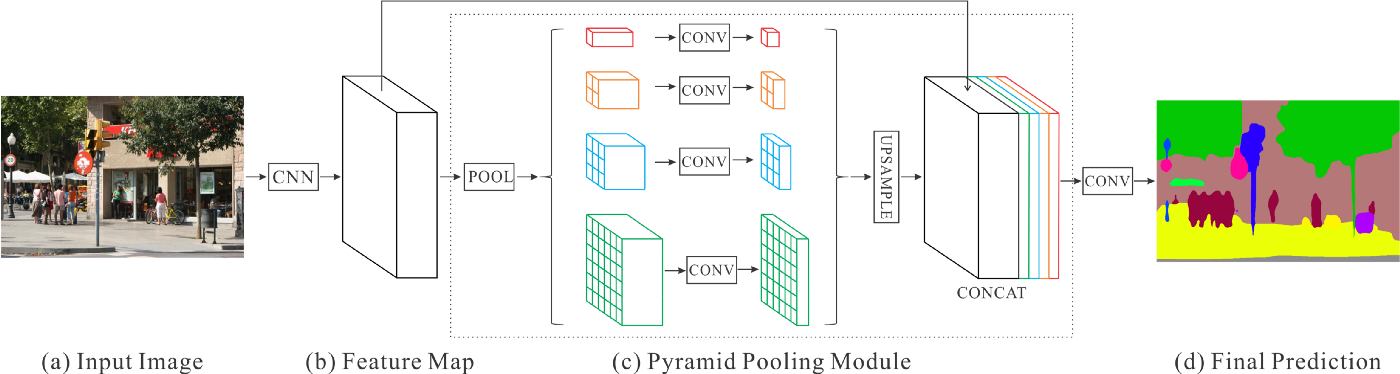

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Entire Class

- Feature Module
- Pyramid Pooling
- Decoder Module
- AuxLoss Module

In [ ]:
class PSPNet(nn.Module):
    def __init__(self, n_classes = 3):
        super(PSPNet, self).__init__()

        # set parameters
        block_config = [3, 4, 6, 3]  # resnet50
        img_size = 475
        img_size_8 = 60  # img_size 1/8로 설정

        # preparations for sub networks
        self.feature_conv = FeatureMap_convolution()
        self.feature_res_1 = ResidualBlockPSP(
            n_blocks=block_config[0], in_channels=128, mid_channels=64, out_channels=256, stride=1, dilation=1)
        self.feature_res_2 = ResidualBlockPSP(
            n_blocks=block_config[1], in_channels=256, mid_channels=128, out_channels=512, stride=2, dilation=1)
        self.feature_dilated_res_1 = ResidualBlockPSP(
            n_blocks=block_config[2], in_channels=512, mid_channels=256, out_channels=1024, stride=1, dilation=2)
        self.feature_dilated_res_2 = ResidualBlockPSP(
            n_blocks=block_config[3], in_channels=1024, mid_channels=512, out_channels=2048, stride=1, dilation=4)

        self.pyramid_pooling = PyramidPooling(in_channels=2048, pool_sizes=[
            6, 3, 2, 1], height=img_size_8, width=img_size_8)

        self.decode_feature = DecodePSPFeature(
            height=img_size, width=img_size, n_classes=n_classes)

        self.aux = AuxiliaryPSPlayers(
            in_channels=1024, height=img_size, width=img_size, n_classes=n_classes)

    def forward(self, x):
        x = self.feature_conv(x)
        x = self.feature_res_1(x)
        x = self.feature_res_2(x)
        x = self.feature_dilated_res_1(x)

        output_aux = self.aux(x)  # Feture embedding -> aux

        x = self.feature_dilated_res_2(x)

        x = self.pyramid_pooling(x)
        output = self.decode_feature(x)

        return (output, output_aux)

## Feature Module (ResNet)

- FeatureMap_convolution
- 2 x residualBlockPSP
- 2 xdilated residualBlockPSP

### FeatureMap_convolution

: extract features of image

3x conv2DBatchNormReLU + 1x Maxpool

In [ ]:
class conv2DBatchNormRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
        super(conv2DBatchNormRelu, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride, padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # inplase = True -> don't save input -> memory efficient

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        outputs = self.relu(x)

        return outputs

In [ ]:
class FeatureMap_convolution(nn.Module):
    def __init__(self):
        super(FeatureMap_convolution, self).__init__()

        # conv1 
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 3, 64, 3, 2, 1, 1, False
        self.cbnr_1 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # conv2
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 64, 3, 1, 1, 1, False
        self.cbnr_2 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # conv3
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 128, 3, 1, 1, 1, False
        self.cbnr_3 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # MaxPooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.cbnr_1(x)
        x = self.cbnr_2(x)
        x = self.cbnr_3(x)
        outputs = self.maxpool(x)
        return outputs

### Residual Block PSP

skip connection을 통해 residual (y-x)를 학습하게 하는 전략

- bottleNeckPSP: Relu{(2x conv2DBatchNormRelu + conv2DBatchNorm) + skip(conv2dBatchNOrm)}
- bottleNeckIdentifyPSP: Relu{(2x conv3dBatchNormRelu + conv2dBatchNorm)+skip(input)}

차이: skip connection에 convolution 적용 여부

Process: bottleNeckPSP + iterations(bottleNeckIdentityPSP)

In [ ]:
class ResidualBlockPSP(nn.Sequential):#if dilation > 2; dilated residual block PSP
    def __init__(self, n_blocks, in_channels, mid_channels, out_channels, stride, dilation):
        super(ResidualBlockPSP, self).__init__()

        # prepare bottleNeckPSP 
        self.add_module(
            "block1",
            bottleNeckPSP(in_channels, mid_channels,
                          out_channels, stride, dilation)
        )

        # prepare for iterations of bottleNeckIdentifyPSP
        for i in range(n_blocks - 1):#iterations: 3, 4, 6, 3 for ResNet-50
            self.add_module(
                "block" + str(i+2),
                bottleNeckIdentifyPSP(
                    out_channels, mid_channels, stride, dilation)
            )

In [ ]:
class conv2DBatchNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
        super(conv2DBatchNorm, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride, padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        outputs = self.batchnorm(x)

        return outputs

#### BottleNeckPSP

In [ ]:
class bottleNeckPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride, dilation):
        super(bottleNeckPSP, self).__init__()

        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, mid_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.cbr_2 = conv2DBatchNormRelu(
            mid_channels, mid_channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False)
        self.cb_3 = conv2DBatchNorm(
            mid_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        #skip connection
        self.cb_residual = conv2DBatchNorm(
            in_channels, out_channels, kernel_size=1, stride=stride, padding=0, dilation=1, bias=False)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = self.cb_residual(x)#skip connection for convolution (conv2dBatchNorm)
        return self.relu(conv + residual)

#### bottleNeckIdentifyPSP

In [ ]:
class bottleNeckIdentifyPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, stride, dilation):
        super(bottleNeckIdentifyPSP, self).__init__()

        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, mid_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.cbr_2 = conv2DBatchNormRelu(
            mid_channels, mid_channels, kernel_size=3, stride=1, padding=dilation, dilation=dilation, bias=False)
        self.cb_3 = conv2DBatchNorm(
            mid_channels, in_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = x#skip connection for input (x)
        return self.relu(conv + residual)

## Pyramid Pooling Module

1. Adatptive Average Pooling layer
2. conv2DBatchNormRelu
3. UpSample layer (F.interpolate)
4. Recombine (기준: channel)


**Usage**: For getting info. of adjacent pixels of object -> high precision 

In [ ]:
class PyramidPooling(nn.Module):
    def __init__(self, in_channels, pool_sizes, height, width):
        super(PyramidPooling, self).__init__()

        # height & width for forward propagation
        self.height = height
        self.width = width

        # number of output channel for each conv layer
        out_channels = int(in_channels / len(pool_sizes))

        # each conv layer
        # pool_sizes: [6, 3, 2, 1]
        self.avpool_1 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[0])#adaptie average pooling layer
        self.cbr_1 = conv2DBatchNormRelu(#conv2DBatchNormRelu
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_2 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[1])
        self.cbr_2 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_3 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[2])
        self.cbr_3 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_4 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[3])
        self.cbr_4 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

    def forward(self, x):

        out1 = self.cbr_1(self.avpool_1(x))
        out1 = F.interpolate(out1, size=(
            self.height, self.width), mode="bilinear", align_corners=True)#UpSample layer

        out2 = self.cbr_2(self.avpool_2(x))
        out2 = F.interpolate(out2, size=(
            self.height, self.width), mode="bilinear", align_corners=True)#UpSample layer

        out3 = self.cbr_3(self.avpool_3(x))
        out3 = F.interpolate(out3, size=(
            self.height, self.width), mode="bilinear", align_corners=True)#UpSample layer

        out4 = self.cbr_4(self.avpool_4(x))
        out4 = F.interpolate(out4, size=(
            self.height, self.width), mode="bilinear", align_corners=True)#UpSample layer

        #dim = 1기준(channel 기준) concatenate(recombine)
        output = torch.cat([x, out1, out2, out3, out4], dim=1)#output size: batch_size x 4096 x 60 x 60

        return output

## Decoder & AuxLoss Module

**Function**:
- read info from tensor and predict label in pixel-level.
- upsample to original size of image


**Process**:
1. conv2DBatchNormRelu
2. Dropout
3. Convolution layer
4. Upsample

In [ ]:
class DecodePSPFeature(nn.Module):
    def __init__(self, height, width, n_classes):
        super(DecodePSPFeature, self).__init__()

        # height & width for forward propagation
        self.height = height
        self.width = width

        
        self.cbr = conv2DBatchNormRelu(
            in_channels=4096, out_channels=512, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(
            in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.cbr(x)#1. conv2DBatchNormRelu
        x = self.dropout(x)#2. Dropout
        x = self.classification(x)#3. Convolution layer
        
        output = F.interpolate(#4. Upsample
            x, size=(self.height, self.width), mode="bilinear", align_corners=True)

        return output

In [ ]:
class AuxiliaryPSPlayers(nn.Module):#same as decoder
    def __init__(self, in_channels, height, width, n_classes):
        super(AuxiliaryPSPlayers, self).__init__()
        self.height = height
        self.width = width

        self.cbr = conv2DBatchNormRelu(
            in_channels=in_channels, out_channels=256, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(
            in_channels=256, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(
            x, size=(self.height, self.width), mode="bilinear", align_corners=True)

        return output

In [ ]:
net = PSPNet(n_classes = 2)
net

PSPNet(
  (feature_conv): FeatureMap_convolution(
    (cbnr_1): conv2DBatchNormRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_2): conv2DBatchNormRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_3): conv2DBatchNormRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (feature_res_1): ResidualBlockPSP(
    (block1): bottleNec

In [ ]:
batch_size = 2
dummy_img = torch.rand(batch_size, 3, 475, 475)

outputs = net(dummy_img)
print(outputs)#계산되는지 확인

(tensor([[[[-0.3845, -0.3637, -0.3430,  ..., -0.4098, -0.4402, -0.4706],
          [-0.3559, -0.3310, -0.3061,  ..., -0.3610, -0.3908, -0.4206],
          [-0.3274, -0.2983, -0.2691,  ..., -0.3122, -0.3414, -0.3706],
          ...,
          [-0.0719, -0.1085, -0.1451,  ..., -0.5777, -0.6146, -0.6515],
          [-0.0398, -0.0811, -0.1224,  ..., -0.5734, -0.6116, -0.6498],
          [-0.0077, -0.0537, -0.0997,  ..., -0.5690, -0.6085, -0.6481]],

         [[-0.3975, -0.4004, -0.4032,  ..., -0.2155, -0.2389, -0.2623],
          [-0.3363, -0.3473, -0.3584,  ..., -0.2275, -0.2467, -0.2659],
          [-0.2751, -0.2943, -0.3135,  ..., -0.2395, -0.2545, -0.2695],
          ...,
          [-0.4118, -0.3968, -0.3818,  ..., -0.1524, -0.1195, -0.0865],
          [-0.4668, -0.4494, -0.4319,  ..., -0.0926, -0.0505, -0.0085],
          [-0.5217, -0.5019, -0.4821,  ..., -0.0327,  0.0184,  0.0694]]],


        [[[ 0.0350,  0.0256,  0.0162,  ..., -0.4510, -0.4615, -0.4719],
          [ 0.0678,  0.0611

## Functions

### Load Pretrain weights & Fine-tune

In [ ]:
psp_net = PSPNet(n_classes = 150)

state_dict = torch.load('/content/weights/pspnet50_ADE20K.pth')
psp_net.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
n_classes = 3#background, left, right
psp_net.decode_feature.classification = nn.Conv2d(in_channels = 512,
                                              out_channels = n_classes,
                                              kernel_size = 1,
                                              stride = 1,
                                              padding = 0)
psp_net.aux.classification = nn.Conv2d(in_channels = 256,
                                   out_channels = n_classes,
                                   kernel_size = 1,
                                   stride = 1,
                                   padding = 0)

In [ ]:
#intinialize replaced conv layers with xavier weights
def weights_init(m):
  if isinstance(m, nn.Conv2d):
    nn.init.xavier_normal_(m.weight.data)
    if m.bias is not None:#if bias exists
      nn.init.constant_(m.bias, 0.0)
psp_net.decode_feature.classification.apply(weights_init)
psp_net.aux.classification.apply(weights_init)

Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))

### PSPLoss = previous PSPLoss + BoundaryLoss

**I made the weights on loss trainable**

In [ ]:
#learnable loss weight param
log_sigma_ce = torch.tensor([1.]).requires_grad_()
log_sigma_aux = torch.tensor([0.4]).requires_grad_()

In [ ]:
import math

def sigmoid(x):
  return 2*((1 / (1 + math.exp(-x)))+0.5)

In [ ]:
class PSPLoss(nn.Module):#PSPLoss = original loss + aux_loss
  def __init__(self, aux_weight = 0.4):#0.4: less important than original loss
    super(PSPLoss, self).__init__()
    self.aux_weight = aux_weight
  
  def forward(self, outputs, targets):#, log_sigma_ce, log_sigma_aux):#, log_sigma_hd):
    loss = DC_and_BD_loss(soft_dice_kwargs= {'batch_dice' : True, 'do_bg' : False, 'smooth' : 1e-5, 'square' : False}, bd_kwargs = {})(outputs[0],targets).cuda()
    loss_aux = F.cross_entropy(outputs[1], targets, reduction = 'mean').cuda()
    return loss+0.3*loss_aux#PSPLoss
    
criterion = PSPLoss(0.3).cuda()


In [ ]:
class PSPLoss(nn.Module):#PSPLoss = original loss + aux_loss
  def __init__(self, aux_weight = 0.4):#0.4: less important than original loss
    super(PSPLoss, self).__init__()
    self.aux_weight = aux_weight
  
  def forward(self, outputs, targets):#, log_sigma_ce, log_sigma_aux):#, log_sigma_hd):
    loss = DC_and_BD_loss(soft_dice_kwargs= {'batch_dice' : True, 'do_bg' : False, 'smooth' : 1e-5, 'square' : False}, bd_kwargs = {})(outputs[0],targets).cuda()
    #loss = F.cross_entropy(outputs[0], targets, reduction = 'mean').cuda()
    loss_aux = F.cross_entropy(outputs[1], targets, reduction = 'mean').cuda()
    #bd_loss = BDLoss()(outputs[0],targets).cuda()
    #print(f"loss: {loss} loss_aux: {loss_aux} bd_loss: {bd_loss}")
    return loss+0.3*loss_aux#PSPLoss
    
criterion = PSPLoss(0.3).cuda()


In [ ]:
schecriterion

PSPLoss()

In [ ]:
loss_weight_list = [log_sigma_ce, log_sigma_aux]#, log_sigma_hd]

### Lr scheduler (cutmix pretrained라서 다 lr을 작게 바꿔줌)

Because it's finetuning, set small lr for modules close to input and large lr for Decoder and AuxLoss modules with replaced conv layers.
However, as the dataset is different for pre-trained weights, experiment on big lr for modules close to input is worth trying


In [ ]:
5e-4 > 1e-3

False

In [ ]:
5e-4 == 0.0005

True

In [ ]:
psp_net = PSPNet(n_classes = 3)
psp_net.load_state_dict(torch.load('/content/drive/MyDrive/2022/LungSegmentation/PSPNet/learnable_hd_pspnet50_10.pth',map_location = 'cuda:0'))#{'cuda:0':'cpu'}))

In [ ]:
optimizer = optim.SGD([
    {'params':psp_net.feature_conv.parameters(),'lr':0.0005},
    {'params':psp_net.feature_res_1.parameters(),'lr':0.0005},
    {'params':psp_net.feature_res_2.parameters(),'lr':0.0005},
    {'params':psp_net.feature_dilated_res_1.parameters(),'lr':0.0005},
    {'params':psp_net.feature_dilated_res_2.parameters(),'lr':0.0005},
    {'params':psp_net.pyramid_pooling.parameters(),'lr':0.0005},
    {'params':psp_net.decode_feature.parameters(),'lr':0.0005},
    {'params':psp_net.aux.parameters(),'lr':0.0005},
    {'params':loss_weight_list, 'lr':0.0005},#trainable ratio
], momentum = 0.9, weight_decay = 0.0001)

In [ ]:
def lambda_epoch(epoch):
  max_epoch = 35
  return math.pow((1-epoch/max_epoch),0.9)

In [ ]:
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda_epoch)

## Adam + Cosine Annealing

In [ ]:
import math
from torch.optim import Optimizer
class _LRScheduler(object):
    def __init__(self, optimizer, last_epoch=-1):
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer
        if last_epoch == -1:
            for group in optimizer.param_groups:
                group.setdefault('initial_lr', group['lr'])
            last_epoch = 0
        else:
            for i, group in enumerate(optimizer.param_groups):
                if 'initial_lr' not in group:
                    raise KeyError("param 'initial_lr' is not specified "
                                   "in param_groups[{}] when resuming an optimizer".format(i))
        self.base_lrs = list(map(lambda group: group['initial_lr'], optimizer.param_groups))
        self.step(last_epoch)

    def state_dict(self):
        """Returns the state of the scheduler as a :class:`dict`.
        It contains an entry for every variable in self.__dict__ which
        is not the optimizer.
        """
        return {key: value for key, value in self.__dict__.items() if key != 'optimizer'}

    def load_state_dict(self, state_dict):
        """Loads the schedulers state.
        Arguments:
            state_dict (dict): scheduler state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        self.__dict__.update(state_dict)

    def get_lr(self):
        raise NotImplementedError

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [ ]:
class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
        self.T_cur = last_epoch
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [ ]:
optimizer = optim.Adam(psp_net.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0)

# Train w/ histogram EQ + learnable BD Loss

In [ ]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [ ]:
def train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs, loss_weight_list):


    # allocate gpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    # accelerate model after stabilization
    torch.backends.cudnn.benchmark = True

    # number of images
    num_train_imgs = len(dataloaders_dict["train"].dataset)
    num_val_imgs = len(dataloaders_dict["val"].dataset)
    batch_size = dataloaders_dict["train"].batch_size
    
    iteration = 1
    logs = []

    # multiple minibatch
    batch_multiplier = 3

    # epoch loop
    for epoch in range(num_epochs):

        # start time
        t_epoch_start = time.time()
        t_iter_start = time.time()
        epoch_train_loss = 0.0  # sum of epoch loss for training
        epoch_val_loss = 0.0  # sum of epoch loss for validation

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        for phase in ["train", "val"]:
            if phase == 'train':
                net.train() 
                scheduler.step()  # optimize scheduler
                optimizer.zero_grad()
                print('（train）')

            else:
                if((epoch+1) % 5 == 0):
                    net.eval()   
                    print('-------------')
                    print('（val）')
                else:
                    #validate once in five training times
                    continue

            
            count = 0  # multiple minibatch
            for imges, anno_class_imges in dataloaders_dict[phase]:
                imges = imges.to(device)
                anno_class_imges = anno_class_imges.to(device)

                
              
                if (phase == 'train') and (count == 0):
                    optimizer.step()
                    optimizer.zero_grad()
                    count = batch_multiplier
                '''
                outputs = psp_net(x)
  y = outputs[0] 
  
  y = y[0].cpu().detach().numpy()
  y = np.argmax(y, axis=0)
  anno_predicted = Image.fromarray(np.uint8(y), mode="P")
  #anno_predicted = anno_predicted.resize((img_width, img_height), Image.NEAREST)
  #print(np.array(anno_class_img).shape,np.array(anno_predicted).shape)
  #break
  dice = dice_coef(np.array(anno_class_img), np.array(anno_predicted))
                '''
             
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(imges)
                    loss = criterion(
                        outputs, anno_class_imges.long()) / batch_multiplier

                    if phase == 'train':
                        loss.backward() 
                        count -= 1 
                        if (iteration % 10 == 0): 
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('iteration {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item()/batch_size*batch_multiplier, duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item() * batch_multiplier
                        iteration += 1
                        

                    # validate
                    else:
                        epoch_val_loss += loss.item() * batch_multiplier

        
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss/num_train_imgs, epoch_val_loss/num_val_imgs))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()
        #log_sigma_ce, log_sigma_aux, log_sigma_hd 
        log_epoch = {'epoch': epoch+1, 'train_loss': epoch_train_loss /
                     num_train_imgs,'val_loss': epoch_val_loss/num_val_imgs}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        if (epoch+1)%5 == 0:
          df.to_csv(f"/content/drive/MyDrive/2022/LungSegmentation/PSPNet/cosine_log_output{epoch+1}.csv")
          torch.save(net.state_dict(), '/content/drive/MyDrive/2022/LungSegmentation/PSPNet/cosine_pspnet50_' +
                str(epoch+1) + '.pth')

    # save last model
    torch.save(net.state_dict(), '/content/drive/MyDrive/2022/LungSegmentation/PSPNet/cosine_pspnet50_' +
               str(epoch+1) + '.pth')

In [ ]:
import time
num_epochs = 50
train_model(psp_net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs, loss_weight_list)#histogramEQ+learnable hd_loss pre-trained with hd

-------------
Epoch 1/50
-------------
（train）


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


iteration 10 || Loss: -1.0369 || 10iter: 6.6164 sec.
iteration 20 || Loss: -0.8711 || 10iter: 6.5730 sec.
iteration 30 || Loss: -1.0432 || 10iter: 6.5842 sec.
iteration 40 || Loss: -1.0399 || 10iter: 6.5740 sec.
iteration 50 || Loss: -0.8855 || 10iter: 6.5627 sec.
iteration 60 || Loss: -1.2240 || 10iter: 6.6239 sec.
iteration 70 || Loss: -0.7951 || 10iter: 6.5899 sec.
iteration 80 || Loss: -1.2649 || 10iter: 6.6407 sec.
iteration 90 || Loss: -0.9398 || 10iter: 6.5845 sec.
iteration 100 || Loss: -1.0975 || 10iter: 6.5719 sec.
iteration 110 || Loss: -0.8765 || 10iter: 6.5555 sec.
iteration 120 || Loss: -0.6896 || 10iter: 6.5966 sec.
iteration 130 || Loss: -0.9960 || 10iter: 6.6916 sec.
iteration 140 || Loss: -0.9674 || 10iter: 6.6454 sec.
iteration 150 || Loss: -0.8689 || 10iter: 6.5893 sec.
iteration 160 || Loss: -0.7504 || 10iter: 6.6136 sec.
iteration 170 || Loss: -1.0818 || 10iter: 6.5467 sec.
iteration 180 || Loss: -1.0605 || 10iter: 6.5783 sec.
iteration 190 || Loss: -1.0762 || 10i

In [ ]:
num_epochs = 35
psp_net = PSPNet(n_classes = 3)
psp_net.load_state_dict(torch.load('/content/drive/MyDrive/2022/LungSegmentation/PSPNet/learnable_hd_pspnet50_10.pth',map_location = 'cuda:0'))#{'cuda:0':'cpu'}))
psp_net.cuda()

PSPNet(
  (feature_conv): FeatureMap_convolution(
    (cbnr_1): conv2DBatchNormRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_2): conv2DBatchNormRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_3): conv2DBatchNormRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (feature_res_1): ResidualBlockPSP(
    (block1): bottleNec

In [ ]:
import time
train_model(psp_net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs, loss_weight_list)#histogramEQ+learnable hd_loss pre-trained with hd

-------------
Epoch 1/30
-------------
（train）


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


iteration 10 || Loss: -0.5442 || 10iter: 21.4676 sec.
iteration 20 || Loss: -0.5436 || 10iter: 14.9226 sec.
iteration 30 || Loss: -1.0423 || 10iter: 14.9151 sec.
iteration 40 || Loss: -1.0180 || 10iter: 13.2107 sec.
iteration 50 || Loss: -1.1915 || 10iter: 13.8204 sec.
iteration 60 || Loss: -1.2362 || 10iter: 14.5338 sec.
iteration 70 || Loss: -0.6924 || 10iter: 12.8887 sec.
iteration 80 || Loss: -0.8037 || 10iter: 12.8009 sec.
iteration 90 || Loss: -1.1270 || 10iter: 13.0255 sec.
iteration 100 || Loss: -1.0507 || 10iter: 13.0213 sec.
iteration 110 || Loss: -0.6610 || 10iter: 12.4277 sec.
iteration 120 || Loss: -0.9415 || 10iter: 10.6230 sec.
iteration 130 || Loss: -0.5842 || 10iter: 11.7653 sec.
iteration 140 || Loss: -0.8149 || 10iter: 12.0185 sec.
iteration 150 || Loss: -0.9805 || 10iter: 12.0550 sec.
iteration 160 || Loss: -1.0721 || 10iter: 11.0954 sec.
iteration 170 || Loss: -1.0403 || 10iter: 11.2483 sec.
iteration 180 || Loss: -0.8320 || 10iter: 10.7302 sec.
iteration 190 || Lo

KeyboardInterrupt: ignored

In [ ]:
def train_model_cpu(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs, loss_weight_list):

    log_sigma_ce, log_sigma_aux = loss_weight_list[0],loss_weight_list[1]#,loss_weight_list[2]

    # allocate gpu
    device = torch.device("cpu")
    net.to(device)
    log_sigma_ce, log_sigma_aux = log_sigma_ce.to(device), log_sigma_aux.to(device)#, log_sigma_hd.to(device)
    # accelerate model after stabilization
    torch.backends.cudnn.benchmark = True

    # number of images
    num_train_imgs = len(dataloaders_dict["train"].dataset)
    num_val_imgs = len(dataloaders_dict["val"].dataset)
    batch_size = dataloaders_dict["train"].batch_size
    
    iteration = 1
    logs = []

    # multiple minibatch
    batch_multiplier = 3

    # epoch loop
    for epoch in range(num_epochs):

        # start time
        t_epoch_start = time.time()
        t_iter_start = time.time()
        epoch_train_loss = 0.0  # sum of epoch loss for training
        epoch_val_loss = 0.0  # sum of epoch loss for validation

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        for phase in ["train", "val"]:
            if phase == 'train':
                net.train() 
                scheduler.step()  # optimize scheduler
                optimizer.zero_grad()
                print('（train）')

            else:
                if((epoch+1) % 5 == 0):
                    net.eval()   
                    print('-------------')
                    print('（val）')
                else:
                    #validate once in five training times
                    continue

            
            count = 0  # multiple minibatch
            for imges, anno_class_imges in dataloaders_dict[phase]:
                imges = imges.to(device)
                anno_class_imges = anno_class_imges.to(device)

                
              
                if (phase == 'train') and (count == 0):
                    optimizer.step()
                    optimizer.zero_grad()
                    count = batch_multiplier
                '''
                outputs = psp_net(x)
  y = outputs[0] 
  
  y = y[0].cpu().detach().numpy()
  y = np.argmax(y, axis=0)
  anno_predicted = Image.fromarray(np.uint8(y), mode="P")
  #anno_predicted = anno_predicted.resize((img_width, img_height), Image.NEAREST)
  #print(np.array(anno_class_img).shape,np.array(anno_predicted).shape)
  #break
  dice = dice_coef(np.array(anno_class_img), np.array(anno_predicted))
                '''
             
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(imges)
                    loss = criterion(
                        outputs, anno_class_imges.long(),log_sigma_ce, log_sigma_aux ) / batch_multiplier

                    if phase == 'train':
                        loss.backward() 
                        count -= 1 
                        if (iteration % 10 == 0): 
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('iteration {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item()/batch_size*batch_multiplier, duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item() * batch_multiplier
                        iteration += 1
                        

                    # validate
                    else:
                        epoch_val_loss += loss.item() * batch_multiplier

        
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss/num_train_imgs, epoch_val_loss/num_val_imgs))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()
        #log_sigma_ce, log_sigma_aux, log_sigma_hd 
        log_epoch = {'epoch': epoch+1, 'train_loss': epoch_train_loss /
                     num_train_imgs,'val_loss': epoch_val_loss/num_val_imgs, 'ce w':log_sigma_ce, 'aux_w':log_sigma_aux}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        if (epoch+1)%5 == 0:
          df.to_csv(f"/content/drive/MyDrive/2022/LungSegmentation/PSPNet/learnable_hd_log_output{epoch+1}.csv")
          torch.save(net.state_dict(), '/content/drive/MyDrive/2022/LungSegmentation/PSPNet/learnable_hd_pspnet50_' +
                str(epoch+1) + '.pth')

    # save last model
    torch.save(net.state_dict(), '/content/drive/MyDrive/2022/LungSegmentation/PSPNet/learnable_hd_pspnet50_' +
               str(epoch+1) + '.pth')

In [ ]:
import time
num_epochs = 35

In [ ]:
loss_weight_list

[tensor([1.], requires_grad=True), tensor([0.4000], requires_grad=True)]

In [ ]:
psp_net = PSPNet(n_classes = 3)
psp_net.load_state_dict(torch.load('/content/drive/MyDrive/2022/LungSegmentation/PSPNet/again_again_hd_pspnet50_10.pth',map_location = {'cuda:0':'cpu'}))

<All keys matched successfully>

In [ ]:
psp_net = PSPNet(n_classes = 3)
psp_net.load_state_dict(torch.load('/content/drive/MyDrive/2022/LungSegmentation/PSPNet/learnable_hd_pspnet50_10.pth',map_location = 'cdua:0'))#{'cuda:0':'cpu'}))

<All keys matched successfully>

In [ ]:
train_model_cpu(psp_net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs, loss_weight_list)#histogramEQ+learnable hd_loss pre-trained with hd

-------------
Epoch 1/35
-------------
（train）


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


iteration 10 || Loss: -0.5089 || 10iter: 322.9426 sec.
iteration 20 || Loss: -0.7391 || 10iter: 328.8856 sec.
iteration 30 || Loss: -0.7373 || 10iter: 322.5745 sec.
iteration 40 || Loss: -0.8946 || 10iter: 329.7250 sec.
iteration 50 || Loss: -0.9907 || 10iter: 328.1645 sec.
iteration 60 || Loss: -0.8228 || 10iter: 323.9546 sec.
iteration 70 || Loss: -0.8103 || 10iter: 324.2679 sec.
iteration 80 || Loss: -0.7303 || 10iter: 324.1558 sec.
iteration 90 || Loss: -0.6474 || 10iter: 318.4490 sec.
iteration 100 || Loss: -0.9047 || 10iter: 317.0622 sec.
iteration 110 || Loss: -0.9757 || 10iter: 318.9424 sec.
iteration 120 || Loss: -0.6345 || 10iter: 312.4602 sec.
iteration 130 || Loss: -1.1336 || 10iter: 315.9364 sec.
iteration 140 || Loss: -0.8731 || 10iter: 315.2623 sec.
iteration 150 || Loss: -0.7398 || 10iter: 318.1720 sec.
iteration 160 || Loss: -0.6270 || 10iter: 315.7718 sec.
iteration 170 || Loss: -0.9169 || 10iter: 318.1306 sec.
iteration 180 || Loss: -0.9356 || 10iter: 320.6923 sec.
i

In [ ]:
train_model(psp_net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs, loss_weight_list)#histogramEQ+learnable hd_loss pre-trained with hd

-------------
Epoch 1/35
-------------
（train）


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


iteration 10 || Loss: -0.0002 || 10iter: 24.8693 sec.
iteration 20 || Loss: 0.0123 || 10iter: 12.7374 sec.
iteration 30 || Loss: 0.0165 || 10iter: 12.9022 sec.
iteration 40 || Loss: 0.0416 || 10iter: 14.1699 sec.
iteration 50 || Loss: 0.0106 || 10iter: 11.9705 sec.
iteration 60 || Loss: 0.0056 || 10iter: 12.4364 sec.
iteration 70 || Loss: 0.0143 || 10iter: 14.3912 sec.
iteration 80 || Loss: 0.0411 || 10iter: 14.7417 sec.
iteration 90 || Loss: 0.0001 || 10iter: 12.0773 sec.
iteration 100 || Loss: 0.0069 || 10iter: 14.3063 sec.
iteration 110 || Loss: 0.0076 || 10iter: 14.0821 sec.
iteration 120 || Loss: 0.0254 || 10iter: 12.4842 sec.
iteration 130 || Loss: 0.0115 || 10iter: 13.0857 sec.
iteration 140 || Loss: 0.0046 || 10iter: 12.3025 sec.
iteration 150 || Loss: 0.0280 || 10iter: 12.3530 sec.
iteration 160 || Loss: 0.0040 || 10iter: 13.6218 sec.
iteration 170 || Loss: 0.0082 || 10iter: 13.2069 sec.
iteration 180 || Loss: 0.0233 || 10iter: 13.5126 sec.
iteration 190 || Loss: 0.0245 || 10i

KeyboardInterrupt: ignored

In [ ]:
#psp_net = PSPNet(n_classes = 3)
#state_dict = torch.load('/content/drive/MyDrive/2022/LungSegmentation/PSPNet/cutmix_pspnet50_25.pth')
#psp_net.load_state_dict(torch.load('/content/drive/MyDrive/2022/LungSegmentation/PSPNet/cutmix_pspnet50_25.pth',map_location = {'cuda:0':'cpu'}))
#psp_net.load_state_dict(state_dict)

In [ ]:
#train_model(psp_net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs=num_epochs)#again again hd_loss pre-trained with hd

In [ ]:
##train_model(psp_net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs=num_epochs)#again hd_loss pre-trained with hd

In [ ]:
#train_model(psp_net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs=num_epochs)#hd_loss

In [ ]:
train_model(psp_net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs=num_epochs)#cutmix

In [ ]:
psp_net.load_state_dict(torch.load(''))

## Again Again Results

In [ ]:
psp_net = PSPNet(n_classes = 3)
#state_dict = torch.load('/content/drive/MyDrive/2022/LungSegmentation/PSPNet/cutmix_pspnet50_25.pth')
psp_net.load_state_dict(torch.load('/content/drive/MyDrive/2022/LungSegmentation/PSPNet/again_again_hd_pspnet50_10.pth',map_location = {'cuda:0':'cpu'}))
#psp_net.load_state_dict(state_dict)

In [ ]:
psp_net.cuda()

In [ ]:
val_dataloader = data.DataLoader(val_dataset, batch_size = 1, shuffle = False)

In [ ]:
left_lung_dice = 0.0
right_lung_dice = 0.0
psp_net.eval()
for img, anno_class_img in val_dataloader:
  #img_index = i
  #x_ = img.unsqueeze(0).cuda()
  #print(x_.size())
  x_ = img.cuda()
  outputs = psp_net(x_)
  y = outputs[0]
  
  y = y[0].cpu().detach().numpy()
  y = np.argmax(y, axis=0)
  anno_predicted = Image.fromarray(np.uint8(y), mode="P")
  
  left_anno_class_img = np.array(anno_class_img)
  left_anno_class_img[left_anno_class_img == 2] = 0
  left_anno_predicted = np.array(anno_predicted)
  left_anno_predicted[left_anno_predicted == 2] = 0

  right_anno_class_img = np.array(anno_class_img)
  right_anno_class_img[right_anno_class_img == 1] = 0
  right_anno_predicted = np.array(anno_predicted)
  right_anno_predicted[right_anno_predicted == 1] = 0
  
  left_dice = dice_coef(left_anno_class_img, left_anno_predicted)
  right_dice = dice_coef(right_anno_class_img, right_anno_predicted)
  left_lung_dice += left_dice
  right_lung_dice += right_dice

RuntimeError: ignored

In [ ]:
left = left_lung_dice/len(val_dataset)
right = right_lung_dice/len(val_dataset)
print(f"dice coefficient for PSPNet on hd loss: left lung {left_lung_dice/len(val_dataset)} right lung: {right_lung_dice/len(val_dataset)} mean dice: {0.5*(left+right)}")

In [ ]:
cutmix_df = pd.read_csv('/content/drive/MyDrive/2022/LungSegmentation/PSPNet/again_again_hd_log_output10.csv')
cutmix_df.tail()

In [ ]:
plt.plot(cutmix_df['train_loss'])
plt.show()

## Again Results

In [ ]:
psp_net = PSPNet(n_classes = 3)
#state_dict = torch.load('/content/drive/MyDrive/2022/LungSegmentation/PSPNet/cutmix_pspnet50_25.pth')
psp_net.load_state_dict(torch.load('/content/drive/MyDrive/2022/LungSegmentation/PSPNet/again_hd_pspnet50_10.pth',map_location = {'cuda:0':'cpu'}))
#psp_net.load_state_dict(state_dict)

In [ ]:
psp_net.cuda()

In [ ]:
val_dataloader = data.DataLoader(val_dataset, batch_size = 1, shuffle = False)

In [ ]:
left_lung_dice = 0.0
right_lung_dice = 0.0
psp_net.eval()
for img, anno_class_img in val_dataloader:
  img_index = i
  #x_ = img.unsqueeze(0).cuda()
  #print(x_.size())
  x_ = img.cuda()
  outputs = psp_net(x_)
  y = outputs[0]
  
  y = y[0].cpu().detach().numpy()
  y = np.argmax(y, axis=0)
  anno_predicted = Image.fromarray(np.uint8(y), mode="P")
  
  left_anno_class_img = np.array(anno_class_img)
  left_anno_class_img[left_anno_class_img == 2] = 0
  left_anno_predicted = np.array(anno_predicted)
  left_anno_predicted[left_anno_predicted == 2] = 0

  right_anno_class_img = np.array(anno_class_img)
  right_anno_class_img[right_anno_class_img == 1] = 0
  right_anno_predicted = np.array(anno_predicted)
  right_anno_predicted[right_anno_predicted == 1] = 0
  
  left_dice = dice_coef(left_anno_class_img, left_anno_predicted)
  right_dice = dice_coef(right_anno_class_img, right_anno_predicted)
  left_lung_dice += left_dice
  right_lung_dice += right_dice

In [ ]:
left = left_lung_dice/len(val_dataset)
right = right_lung_dice/len(val_dataset)
print(f"dice coefficient for PSPNet on hd loss: left lung {left_lung_dice/len(val_dataset)} right lung: {right_lung_dice/len(val_dataset)} mean dice: {0.5*(left+right)}")

In [ ]:
cutmix_df = pd.read_csv('/content/drive/MyDrive/2022/LungSegmentation/PSPNet/again_hd_log_output10.csv')
cutmix_df.tail()

In [ ]:
plt.plot(cutmix_df['train_loss'])
plt.show()

In [ ]:
train_model(psp_net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs=num_epochs)

In [ ]:
pd.read_csv('log_output30.csv').tail)

In [ ]:
!cp /content/weights/pspnet50_10.pth /content/drive/MyDrive/2022/LungSegmentation/PSPNet/

In [ ]:
!cp /content/log_output30.csv /content/drive/MyDrive/2022/LungSegmentation/PSPNet/

# Inference again again

In [ ]:
val_img_list,val_anno_list = test_img_list,test_anno_list
img_index = 4
for i in range(img_index):
  img_index = i
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(10, 5))
  image_file_path = val_img_list[img_index]
  img_original = Image.open(image_file_path)   
  img_width, img_height = img_original.size
  ax1.set_title("input")
  ax1.imshow(img_original)
  ax1.axis('off')
  
  anno_file_path = val_anno_list[img_index]
  anno_class_img = Image.open(anno_file_path) 
  p_palette = anno_class_img.getpalette()
  ax2.set_title("target")
  ax2.imshow(anno_class_img)
  ax2.axis('off')

  psp_net.cuda()
  psp_net.eval()

  img, anno_class_img = val_dataset.__getitem__(img_index)
  x = img.unsqueeze(0).cuda() 
  outputs = psp_net(x)
  y = outputs[0] 
  
  y = y[0].cpu().detach().numpy()
  y = np.argmax(y, axis=0)
  anno_predicted = Image.fromarray(np.uint8(y), mode="P")
  #anno_predicted = anno_predicted.resize((img_width, img_height), Image.NEAREST)
  #print(np.array(anno_class_img).shape,np.array(anno_predicted).shape)
  #break
  
  left_anno_class_img = np.array(anno_class_img)
  left_anno_class_img[left_anno_class_img == 2] = 0
  left_anno_predicted = np.array(anno_predicted)
  left_anno_predicted[left_anno_predicted == 2] = 0

  right_anno_class_img = np.array(anno_class_img)
  right_anno_class_img[right_anno_class_img == 1] = 0
  right_anno_predicted = np.array(anno_predicted)
  right_anno_predicted[right_anno_predicted == 1] = 0
  
  left_dice = dice_coef(left_anno_class_img, left_anno_predicted)
  right_dice = dice_coef(right_anno_class_img, right_anno_predicted)
  ax3.set_title(f"predicted (dice for left lung: {str(left_dice)[:4]} right: {str(right_dice)[:4]})")
  ax3.imshow(np.array(anno_predicted))
  ax3.axis('off')
  
  
  #ax3.show()

# Inference again

In [ ]:
#psp_net.load_state_dict(torch.load('/content/drive/MyDrive/2022/LungSegmentation/PSPNet/again_aug_pspnet50_50.pth',map_location = {'cuda:0':'cpu'}))

<All keys matched successfully>

In [ ]:
val_img_list,val_anno_list = test_img_list,test_anno_list

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


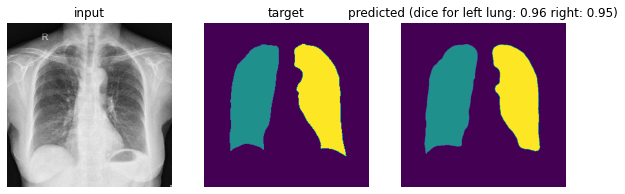

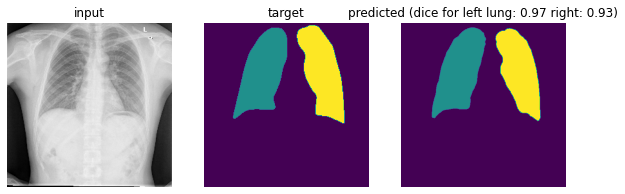

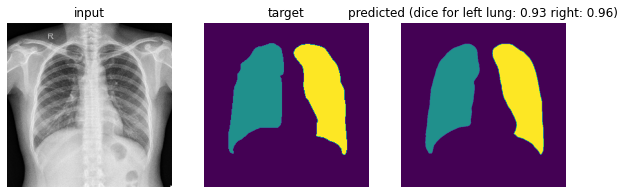

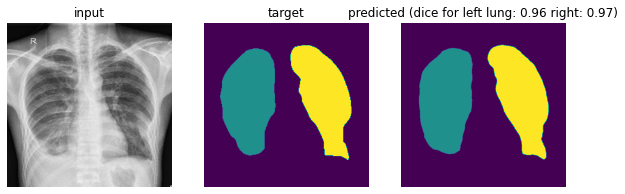

In [ ]:
img_index = 4
for i in range(img_index):
  img_index = i
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(10, 5))
  image_file_path = val_img_list[img_index]
  img_original = Image.open(image_file_path)   
  img_width, img_height = img_original.size
  ax1.set_title("input")
  ax1.imshow(img_original)
  ax1.axis('off')
  
  anno_file_path = val_anno_list[img_index]
  anno_class_img = Image.open(anno_file_path) 
  p_palette = anno_class_img.getpalette()
  ax2.set_title("target")
  ax2.imshow(anno_class_img)
  ax2.axis('off')

  psp_net.cuda()
  psp_net.eval()

  img, anno_class_img = val_dataset.__getitem__(img_index)
  x = img.unsqueeze(0).cuda() 
  outputs = psp_net(x)
  y = outputs[0] 
  
  y = y[0].cpu().detach().numpy()
  y = np.argmax(y, axis=0)
  anno_predicted = Image.fromarray(np.uint8(y), mode="P")
  #anno_predicted = anno_predicted.resize((img_width, img_height), Image.NEAREST)
  #print(np.array(anno_class_img).shape,np.array(anno_predicted).shape)
  #break
  
  left_anno_class_img = np.array(anno_class_img)
  left_anno_class_img[left_anno_class_img == 2] = 0
  left_anno_predicted = np.array(anno_predicted)
  left_anno_predicted[left_anno_predicted == 2] = 0

  right_anno_class_img = np.array(anno_class_img)
  right_anno_class_img[right_anno_class_img == 1] = 0
  right_anno_predicted = np.array(anno_predicted)
  right_anno_predicted[right_anno_predicted == 1] = 0
  
  left_dice = dice_coef(left_anno_class_img, left_anno_predicted)
  right_dice = dice_coef(right_anno_class_img, right_anno_predicted)
  ax3.set_title(f"predicted (dice for left lung: {str(left_dice)[:4]} right: {str(right_dice)[:4]})")
  ax3.imshow(np.array(anno_predicted))
  ax3.axis('off')
  
  
  #ax3.show()

# Results

In [ ]:
left_lung_dice = 0.0
right_lung_dice = 0.0
psp_net.eval()
for i in range(len(val_dataset)):
  img_index = i
  img, anno_class_img = val_dataset.__getitem__(img_index)
  x = img.unsqueeze(0).cuda() 
  outputs = psp_net(x)
  y = outputs[0] 
  
  y = y[0].cpu().detach().numpy()
  y = np.argmax(y, axis=0)
  anno_predicted = Image.fromarray(np.uint8(y), mode="P")
  
  left_anno_class_img = np.array(anno_class_img)
  left_anno_class_img[left_anno_class_img == 2] = 0
  left_anno_predicted = np.array(anno_predicted)
  left_anno_predicted[left_anno_predicted == 2] = 0

  right_anno_class_img = np.array(anno_class_img)
  right_anno_class_img[right_anno_class_img == 1] = 0
  right_anno_predicted = np.array(anno_predicted)
  right_anno_predicted[right_anno_predicted == 1] = 0
  
  left_dice = dice_coef(left_anno_class_img, left_anno_predicted)
  right_dice = dice_coef(right_anno_class_img, right_anno_predicted)
  left_lung_dice += left_dice
  right_lung_dice += right_dice

RuntimeError: ignored

In [ ]:
left = left_lung_dice/len(val_dataset)
right = right_lung_dice/len(val_dataset)
print(f"dice coefficient for PSPNet: left lung {left_lung_dice/len(val_dataset)} right lung: {right_lung_dice/len(val_dataset)} mean dice: {0.5*(left+right)}")

dice coefficient for PSPNet: left lung 0.9538515486106128 right lung: 0.931253878578914 mean dice: 0.9425527135947633


# Train again

In [ ]:
optimizer = optim.SGD([
    {'params':psp_net.feature_conv.parameters(),'lr':1e-3},
    {'params':psp_net.feature_res_1.parameters(),'lr':1e-3},
    {'params':psp_net.feature_res_2.parameters(),'lr':1e-3},
    {'params':psp_net.feature_dilated_res_1.parameters(),'lr':1e-3},
    {'params':psp_net.feature_dilated_res_2.parameters(),'lr':1e-3},
    {'params':psp_net.pyramid_pooling.parameters(),'lr':1e-3},
    {'params':psp_net.decode_feature.parameters(),'lr':1e-2},
    {'params':psp_net.aux.parameters(),'lr':1e-2},
], momentum = 0.9, weight_decay = 0.0001)

In [ ]:
def lambda_epoch(epoch):
  max_epoch = 50
  return math.pow((1-epoch/max_epoch),0.9)

In [ ]:
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda_epoch)

In [ ]:
train_model(psp_net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs=50)

-------------
Epoch 1/50
-------------
（train）


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


iteration 10 || Loss: 0.0116 || 10iter: 11.4335 sec.
iteration 20 || Loss: 0.0106 || 10iter: 11.3558 sec.
iteration 30 || Loss: 0.0115 || 10iter: 11.4399 sec.
iteration 40 || Loss: 0.0146 || 10iter: 11.8902 sec.
iteration 50 || Loss: 0.0074 || 10iter: 11.5610 sec.
iteration 60 || Loss: 0.0118 || 10iter: 11.3921 sec.
iteration 70 || Loss: 0.0086 || 10iter: 11.3945 sec.
iteration 80 || Loss: 0.0084 || 10iter: 11.6236 sec.
iteration 90 || Loss: 0.0084 || 10iter: 11.3290 sec.
iteration 100 || Loss: 0.0066 || 10iter: 11.3182 sec.
-------------
epoch 1 || Epoch_TRAIN_Loss:0.0102 ||Epoch_VAL_Loss:0.0000
timer:  124.8537 sec.
-------------
Epoch 2/50
-------------
（train）
iteration 110 || Loss: 0.0108 || 10iter: 11.5862 sec.
iteration 120 || Loss: 0.0117 || 10iter: 11.5347 sec.
iteration 130 || Loss: 0.0122 || 10iter: 11.5861 sec.
iteration 140 || Loss: 0.0073 || 10iter: 11.4497 sec.
iteration 150 || Loss: 0.0109 || 10iter: 11.6573 sec.
iteration 160 || Loss: 0.0116 || 10iter: 11.5937 sec.
ite

## CPU Result

In [ ]:
left_lung_dice = 0.0
right_lung_dice = 0.0

for i in range(len(val_dataset)):
  img_index = i
  img, anno_class_img = val_dataset.__getitem__(img_index)
  x = img.unsqueeze(0)#.numpy()#.cuda() 
  outputs = psp_net(x)
  y = outputs[0] 
  
  y = y[0].detach().numpy()#.cpu().detach().numpy()
  y = np.argmax(y, axis=0)
  anno_predicted = Image.fromarray(np.uint8(y), mode="P")
  
  left_anno_class_img = np.array(anno_class_img)
  left_anno_class_img[left_anno_class_img == 2] = 0
  left_anno_predicted = np.array(anno_predicted)
  left_anno_predicted[left_anno_predicted == 2] = 0

  right_anno_class_img = np.array(anno_class_img)
  right_anno_class_img[right_anno_class_img == 1] = 0
  right_anno_predicted = np.array(anno_predicted)
  right_anno_predicted[right_anno_predicted == 1] = 0
  
  left_dice = dice_coef(left_anno_class_img, left_anno_predicted)
  right_dice = dice_coef(right_anno_class_img, right_anno_predicted)
  left_lung_dice += left_dice
  right_lung_dice += right_dice

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
left = left_lung_dice/len(val_dataset)
right = right_lung_dice/len(val_dataset)
print(f"dice coefficient for PSPNet: left lung {left_lung_dice/len(val_dataset)} right lung: {right_lung_dice/len(val_dataset)} mean dice: {0.5*(left+right)}")

dice coefficient for PSPNet: left lung 0.9671982725284276 right lung: 0.9553668443762808 mean dice: 0.9612825584523542
